# Predict Annual Water Usage with ARIMA
###### by Putri Bunga Rahmalita
<br>
Background : The Dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per capita per day, and there are 79 observations.
<br><br>
Objective : Create a python script for the Use Case below, please upload the script after you finish. The Problem is to predict annual water usage.

## Import Package

In [213]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).

In [214]:
df = pd.read_csv('water.csv', skipfooter=2)
df.head()

,Year,"Baltmore city annual water use, liters per capita per day, 1885-1968"
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


#### The code below is to rename the features from data which is feature "Baltmore city annual water use, liters per capita per day, 1885-1968" is rename into "annualwater"

In [215]:
rename = {"Baltmore city annual water use, liters per capita per day, 1885-1968" : "annualwater"}
df.rename(columns=rename,inplace=True)

In [216]:
df.head()

,Year,annualwater
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


#### The code below is to split data, one for model development (dataset.csv) and the other for validation (validation.csv).

In [217]:
split = len(df) - 19
dataset, validation = df[0:split], df[split:]
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

I split data into 60 for model development (dataset.csv) and 19 other for validation (validation.csv). Because in ARIMA model I want to split data 50:50, so I just want the data more evenly and round.

## Create summary of the dataset, with python function.

In [218]:
data = dataset.copy()

#### The code below is to know dimension of data

In [219]:
data.shape

(60, 2)

#### The code below is to know summary of numerical data
(you will know count, mean, standard deviation, min value, Q1, Q2, Q3, and max value from the data) 

In [220]:
data.describe()

,Year,annualwater
count,60.000000,60.000000
mean,1914.500000,487.350000
std,17.464249,69.319409
min,1885.000000,344.000000
25%,1899.750000,454.000000
50%,1914.500000,486.500000
75%,1929.250000,515.000000
max,1944.000000,662.000000


#### The code below is to know data types from each features

In [221]:
data.dtypes

Year           int64
annualwater    int64
dtype: object

#### The code below is to know missing value from data

In [222]:
data.isnull().sum().sort_values(ascending = False)

annualwater    0
Year           0
dtype: int64

#### From the result above it can be seen that there is no missing value in the data

## Create A line plot of a time series dataset, it will provide a lot of insight into the problem.

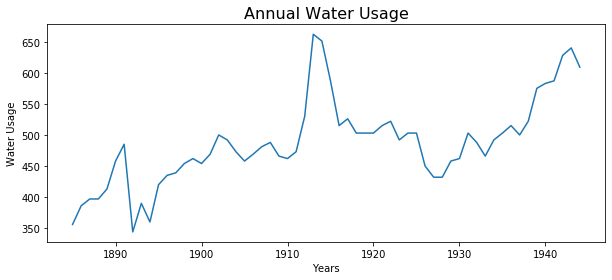

In [223]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(data['Year'],data['annualwater'])
ax.set_title('Annual Water Usage', fontsize=16)
plt.xlabel('Years')
plt.ylabel('Water Usage')
plt.show()

#### From the line plot above it can be seen that water usage can be seen that the use of water every year has increased. However, in the year 1892 to 1894 had experienced a decline. After 1895 the use of water has increased rapidly because water needs more and more. But in 1916 water ussage had decrease and and increased again in 1929. The decreased water use can be caused by the possibility of a clean water crisis that is affecting Baltimore or humans have realized to save water.

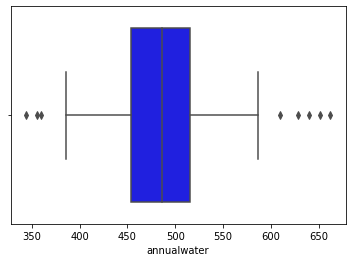

In [224]:
sns.boxplot(data['annualwater'], color ='blue',orient = "h")

#### From the box plot can be known there is some outlier from annualwater feature

### Estimating trend

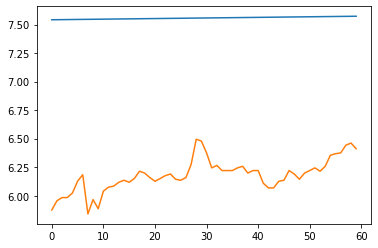

In [225]:
data_logScale = np.log(data)
plt.plot(data_logScale)

### Perform Dickey-Fuller test

In [226]:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data['annualwater'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)' %key] = value
  
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.018413
p-value                         0.278559
#Lags Used                      2.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


Perform Dickey-Fuller test is used to known whether the data is stationary or not.<br>
From the results above can be known that p-value > 0.05. So, the dataset is not stationary. Because the dataset isn't 
stationary must differencing data so that the data is stationary.

### Differencing data
Used to get the stationary dataset

In [227]:
diff = data - data.shift(1)
diff = diff.dropna()

### Perform Dickey-Fuller test again

In [228]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(diff['annualwater'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)' %key] = value
  
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -5.760106e+00
p-value                        5.698468e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


The p-value < 0.05 so it can be said that the data has been stationary after going through the differencing stages.

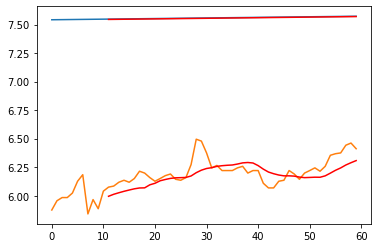

In [247]:
movingAverage = data_logScale.rolling(window=12).mean()
moveSTD = data_logScale.rolling(window=12).std()
plt.plot(data_logScale)
plt.plot(movingAverage, color='red')

## Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.

In [229]:
dataset['decade'] = (dataset['Year'] // 10) * 10 + 5

In [230]:
dataset.loc[(dataset['Year'] % 10) == 0, 'decade'] = dataset['decade'] - 10

In [231]:
dataset['decade_range'] = dataset['decade'].astype('str') + ' - ' + \
(dataset['decade'] + 10).astype('str') 

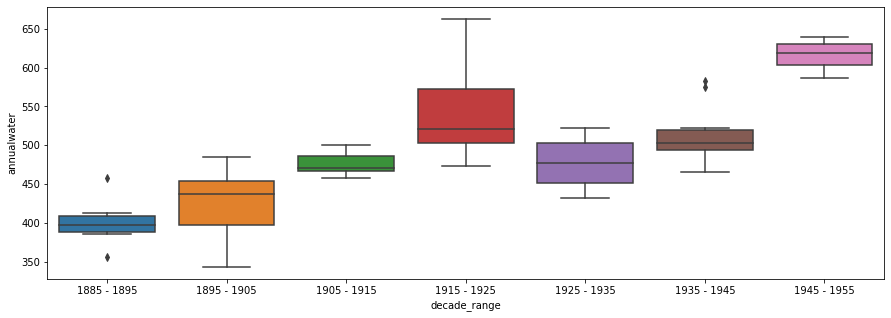

In [232]:
plt.figure(figsize=(15,5))
sns.boxplot(x="decade_range", y="annualwater", data=dataset)   
plt.show()
plt.clf()
plt.close()

From the box plot above can be known that the longer the use of water will increase every decade.

#### Set year value to index

In [233]:
data = data.set_index(data['Year'])

#### Drop unuse column

In [234]:
data.drop(columns=['Year'], inplace=True)

# Create models using ARIMA

#### Import package arima from sklearn

In [235]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#### The code below is to split the dataset into train and test sets directly
The first 50% of the dataset will be held back to train the model.<br>
The remaining 50% of the dataset will be iterated and test the model.

In [236]:
data = data.astype('float64')
train_size = int(len(data)*0.5)
train = data[0:train_size]
test = data[train_size:]
print(train.shape)
print(test.shape)

(30, 1)
(30, 1)


#### The code below is to create arima model
The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.<br>
Use an ARIMA(0,1,0) on the raw data may be a good starting point.

In [237]:
arima_order = (0,1,0)
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.annualwater   No. Observations:                   29
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -149.691
Method:                           css   S.D. of innovations             42.217
Date:                Thu, 10 Oct 2019   AIC                            303.382
Time:                        17:37:20   BIC                            306.117
Sample:                             1   HQIC                           304.239
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1724      7.840      1.298      0.205      -5.193      25.538


In [238]:
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['predict'], index=test.index)
df_test['actual'] = test.values
df_test

,predict,actual
Year,,
1915,661.172414,587.0
1916,671.344828,515.0
1917,681.517241,526.0
1918,691.689655,503.0
1919,701.862069,503.0
1920,712.034483,503.0
1921,722.206897,515.0
1922,732.379310,522.0
1923,742.551724,492.0


### Visualization with line plot

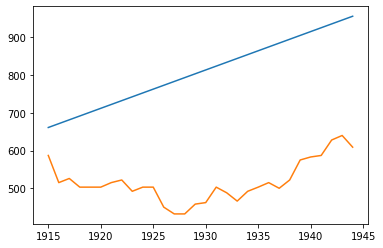

In [239]:
plt.plot(df_test['predict'])
plt.plot(df_test['actual'])

From the line plot above can be known that the predict value and actual value have big difference in value.

## Calculate the RMSE using the helper function from the scikit-learn library, from dataset only (ARIMA (0,1,0)

#### The code below is to calculate the RMSE
RMSE will show you on average, how much the error/the model was wrong/gap between predection and expected value per capita per day for each prediction made.

In [240]:
mse = mean_squared_error(df_test['actual'], df_test['predict'])
rmse = np.sqrt(mse)
rmse

302.35404356077487

From the result above the RMSE value is 302.354. The value is relatively large, so ARIMA(0,1,0) still not good enough for this dataset. For that result I find p,d,and q value with ACF and PACF Plot to get the best result.

## ACF and PACF Plots

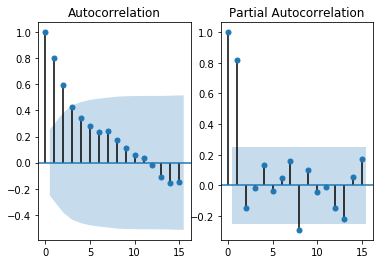

In [241]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pyplot.figure()
pyplot.subplot(1,2,1)
plot_acf(data, ax=pyplot.gca(),lags=15)
pyplot.subplot(1,2,2)
plot_pacf(data, ax=pyplot.gca(), lags=15)
pyplot.show()

#### From the ACF PACF plot above it can be seen that for the correlation plot, that the ACF plot is exponential or sinusoidal and the PACF plot is cut off after the 1st lag. So, the model that fits the plot above is ARIMA (1,0,0)

from the command it is said that "use an ARIMA(0,1,0) on the raw data may be a good starting point." <br>
But I use ARIMA (1,0,0) based on ACF PACF plot.

In [242]:
arima_order = (1,0,0)
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                              ARMA Model Results                              
Dep. Variable:            annualwater   No. Observations:                   30
Model:                     ARMA(1, 0)   Log Likelihood                -156.047
Method:                       css-mle   S.D. of innovations             42.823
Date:                Thu, 10 Oct 2019   AIC                            318.095
Time:                        17:37:34   BIC                            322.298
Sample:                             0   HQIC                           319.439
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               473.1348     56.507      8.373      0.000     362.382     583.887
ar.L1.annualwater     0.8856      0.104      8.491      0.000       0.681       1.090
                        

#### The code below is to predict value from model
When model trained, a one-step prediction made a the prediction stored for later evaluation.

In [252]:
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['predict'], index=test.index)
df_test['actual'] = test.values
df_test

,predict,actual
Year,,
1915,630.648760,587.0
1916,612.626098,515.0
1917,596.665580,526.0
1918,582.531255,503.0
1919,570.014173,503.0
1920,558.929289,503.0
1921,549.112731,515.0
1922,540.419379,522.0
1923,532.720716,492.0


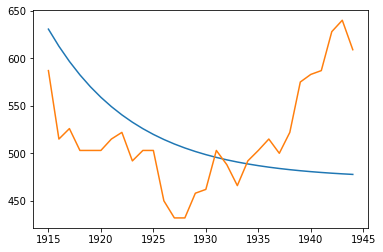

In [244]:
plt.plot(df_test['predict'])
plt.plot(df_test['actual'])

From the result above can be concluded that the actual observation from the test dataset will be added to the training dataset for the next iteration. The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.

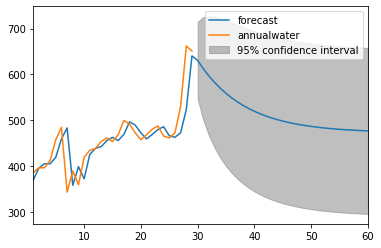

In [258]:
arima_fit.plot_predict(1,60)
x=arima_fit.forecast(steps=60)

From the plot above can be known that forecast value have a difference with actual value but it is relatively low.

## Calculate the RMSE using the helper function from the scikit-learn library, from dataset only (ARIMA 1,0,0)


#### The code below is to calculate the RMSE
RMSE will show you on average, how much the error/the model was wrong/gap between predection and expected value per capita per day for each prediction made.

In [245]:
mse = mean_squared_error(df_test['actual'], df_test['predict'])
rmse = np.sqrt(mse)
rmse

71.42826886806374

#### From the result above can be conclude RMSE = 70.448. For the dataset the RMSE value is relatively low. Noted that a low RMSE value indicates that the variation in values produced by a forecast model approaches the variation in the value of obesity.

If you want to know value of ME, MAPE, MAE, and MPE :
#### The code below is to calculate ME, MAPE, MAE, and MPE

In [246]:
mape = np.mean(np.abs(df_test['predict'] - df_test['actual'])/np.abs(df_test['actual']))
me = np.mean(df_test['predict'] - df_test['actual'])             
mae = np.mean(np.abs(df_test['predict'] - df_test['actual']))    
mpe = np.mean((df_test['predict'] - df_test['actual'])/df_test['actual']) 
print ({'ME':me, 'MAPE':mape, 'MAE': mae, 'MPE': mpe})

{'ME': 0.5911201723188394, 'MAPE': 0.10798989218400729, 'MAE': 57.655614814486164, 'MPE': 0.011784434875034167}


Mean Absolute Error (MAE), Mean Error (ME), MAPE (Mean Absolute Percentage Error), MPE (Mean Percentage Error) <br>
Error value above usually used if you want to compare several time series models

# Conclusion
From the model above can be known that we can predict annual water usage with ARIMA with p, d, and q value is (1,0,0) because the value indicates that the variation in values produced by a forecast model approaches the variation in the value of obesity. So predictions can be used for future water use. If the prediction of water use increases, a program must be held so that humans can save more water, because water is a resource that cannot be supported.

![water](https://images-na.ssl-images-amazon.com/images/I/61xovegvTEL._SY679_.jpg)